In [17]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split as train_test_split
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [87]:
%run ./DataWrangler.ipynb


<class 'pandas.core.frame.DataFrame'>
Int64Index: 425816 entries, 1 to 618472
Data columns (total 83 columns):
Date                   425816 non-null datetime64[ns]
Store                  425816 non-null float64
DayOfWeek              425816 non-null float64
Sales                  425816 non-null float64
Customers              425816 non-null float64
Open                   425816 non-null float64
Promo                  425816 non-null float64
SchoolHoliday          425816 non-null float64
CompetitionDistance    425816 non-null float64
year                   425816 non-null int64
dayofyear              425816 non-null int64
weekofyear             425816 non-null int64
StateHoliday_0         425816 non-null uint8
StateHoliday_a         425816 non-null uint8
StateHoliday_b         425816 non-null uint8
StateHoliday_c         425816 non-null uint8
StoreType_a            425816 non-null uint8
StoreType_b            425816 non-null uint8
StoreType_c            425816 non-null uint8
StoreType

In [109]:
df = data_new
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 425816 entries, 1 to 618472
Data columns (total 83 columns):
Date                   425816 non-null datetime64[ns]
Store                  425816 non-null float64
DayOfWeek              425816 non-null float64
Sales                  425816 non-null float64
Customers              425816 non-null float64
Open                   425816 non-null float64
Promo                  425816 non-null float64
SchoolHoliday          425816 non-null float64
CompetitionDistance    425816 non-null float64
year                   425816 non-null int64
dayofyear              425816 non-null int64
weekofyear             425816 non-null int64
StateHoliday_0         425816 non-null uint8
StateHoliday_a         425816 non-null uint8
StateHoliday_b         425816 non-null uint8
StateHoliday_c         425816 non-null uint8
StoreType_a            425816 non-null uint8
StoreType_b            425816 non-null uint8
StoreType_c            425816 non-null uint8
StoreType

In [18]:
# #returns stats if numerical, returns value counts if string 
# def describer(df):
#     for column in df.columns:
#         print(column)
#         if df.dtypes[column] == object:
#             print (df[column].value_counts())
#         else: print(df[column].describe())
#         print('\n')

In [110]:
#rearranging the sales column so that it is at the end
cols = list(df.columns.values) #Make a list of all of the columns in the df
cols.pop(cols.index('Sales')) #Remove sales from list
df = df[cols + ['Sales']] #Create new dataframe with sales right at the end 

In [111]:
del df['Date'] #this is now redundant so we kill it 
del df['SalesPerCustomer'] #this is now redundant so we kill it 
#del df['Unnamed: 0'] #do we need this? seems redundant so let's kill

In [112]:
df=df[['av_SalesPerCustomer','Customers','Promo','CompetitionDistance','dayofweek','dayofmonth','year','Sales']]

In [113]:
#create feature matrix of everything up to sales, create labels from sales 
X, y = df.iloc[:, :-1],df.iloc[:, -1]

In [114]:
# creating XGB optimised data structure. we will need this for our cross validation model later
df_DM = xgb.DMatrix(data=X, label=y)

In [115]:
#randomly creating train and test subsets. may need to refine this 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [116]:
#here we decide the parameters that we are going to use in the model
params = {"objective":"reg:squarederror", #type of regressor, shouldnt change
          'colsample_bytree': 0.4, #percentage of features used per tree. High value can lead to overfitting.
          'learning_rate': 0.02, #step size shrinkage used to prevent overfitting. Range is [0,1]
          'max_depth': 5, #determines how deeply each tree is allowed to grow during any boosting round. keep this low! this will blow up our variance if high
          'alpha': 15, #L1 regularization on leaf weights. A large value leads to more regularization. Could consider l2 euclidiean regularisation
          'n_estimators': 750, #number of trees you want to build.
          'n_jobs': -1} #should optimise core usage on pc

#now we must instantiate the XGB regressor by calling XGB regressor CLASS from the XGBoost library, we must give it the hypter parameters as arguments
xg_reg = xgb.XGBRegressor(**params)

In [117]:
#Fit the regressor to the training set and make predictions for the test set using .fit() and .predict() methods
xg_reg.fit(X_train, y_train)
preds = xg_reg.predict(X_test)
#defining our error metric
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 606.700575


In [118]:
#the following is a cross validation technique, note that dtrain calls the XGB optimised data structure that we created earlier.
#params is taking our earlier set of parameters and 'exploding' them into this
#nfold decides the number of cross validation sets we are creating.
#num_boost_round is RESOURCE INTENSIVE, decides the number of trees (analogous to n estimators) 
#early stopping rounds finishes training of the models early if the hold-out metric ("rmse" in our case) does not improve for a given number of rounds.
#seed is for reproducibility of results 
cv_results = xgb.cv(dtrain=df_DM,
                    params=params,
                    nfold=3,
                    num_boost_round=500,
                    early_stopping_rounds=3,
                    metrics="rmse",
                    as_pandas=True,
                    seed=42)

In [108]:
#final train and test RMSE metrics for each boosting round
cv_results

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,7360.318847,4.552670,7360.325846,9.102427
1,7222.823568,13.652063,7222.737956,1.647593
2,7100.857585,13.311970,7100.856933,1.831631
3,6980.824870,14.206788,6980.798340,1.174893
4,6857.928711,17.748681,6857.876790,7.551380
5,6733.112956,24.178988,6732.917318,12.433312
6,6616.647461,16.608350,6616.588867,7.466776
7,6502.144369,10.044559,6502.128906,8.510856
8,6388.235840,13.311888,6388.075684,0.507608
9,6273.625976,9.702645,6273.547038,6.792166


In [85]:
#final result 
print((cv_results["test-rmse-mean"]).tail(1))

348    8.636894
Name: test-rmse-mean, dtype: float64


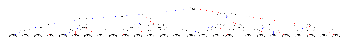

In [39]:
#you may need to install graphviz to view the below code 
#conda install graphviz (inside terminal)
#conda install python-graphviz (inside terminal)
#then it should be fine 
xgb.plot_tree(xg_reg,num_trees=2)
plt.rcParams['figure.figsize'] = [400, 400]
plt.show()

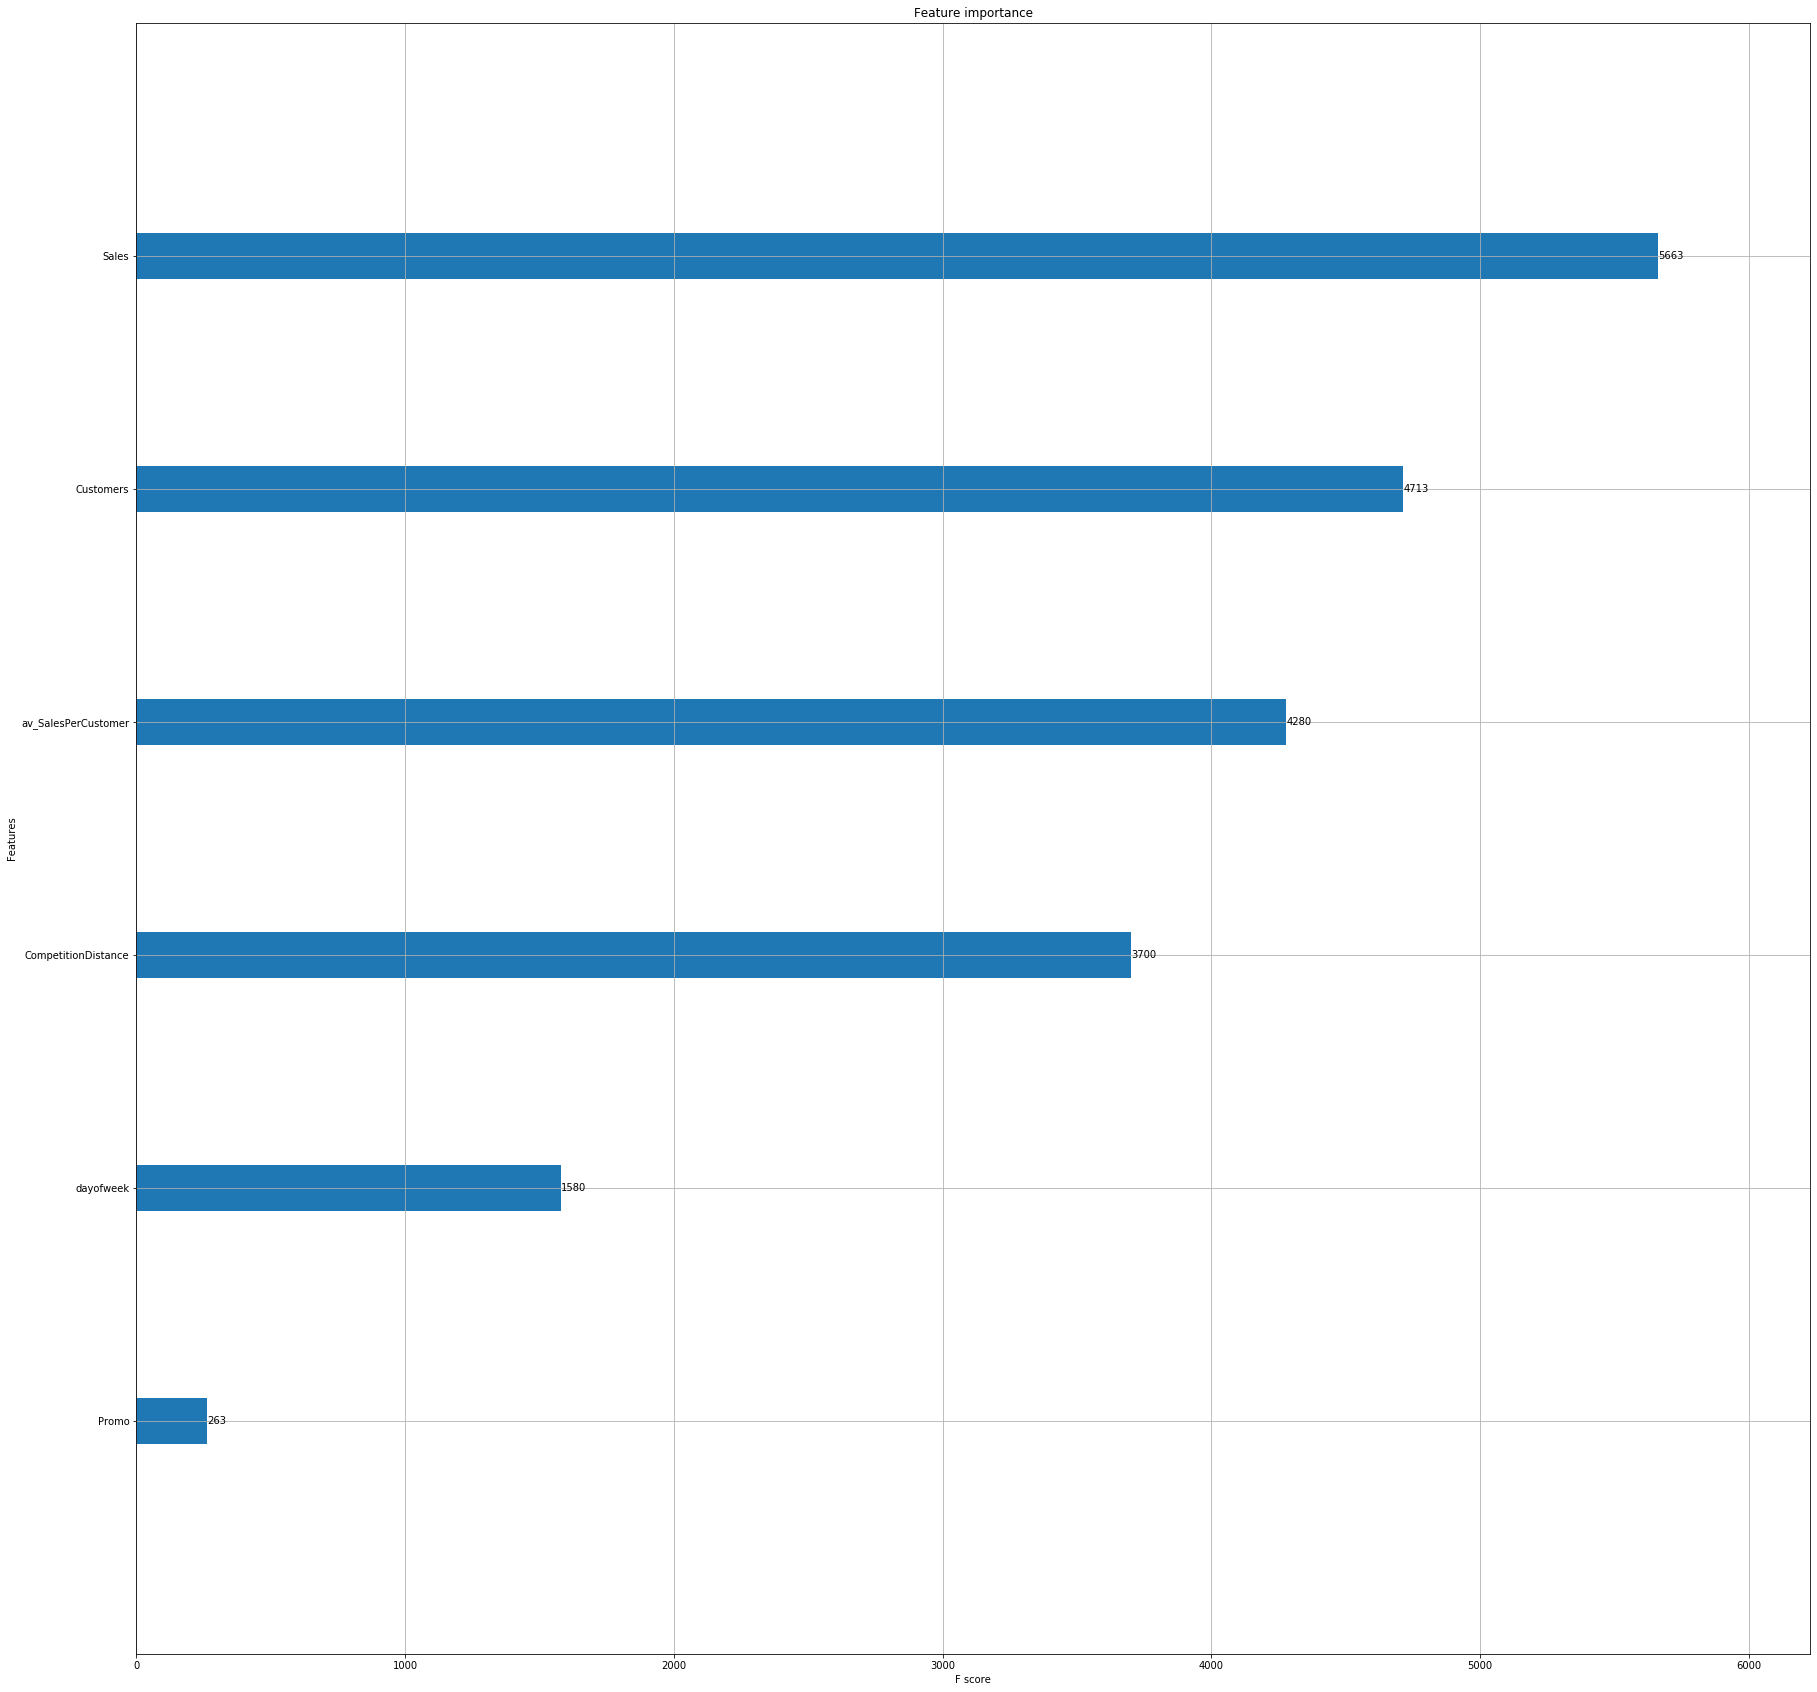

In [86]:
fig, ax = plt.subplots(figsize=(30, 30))
plot_importance(xg_reg, ax=ax)